### Import libraries

In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:82.5% !important}</style>'))

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score

import eli5
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Paths to directories and files

In [5]:
TRAIN_DATASET_PATH = 'data/train_sessions.csv'
TEST_DATASET_PATH = 'data/test_sessions.csv'
SITE_DIC_PATH = 'data/site_dic.pkl'
RES_PATH = 'data/result_submission.csv'

### Loading data

In [6]:
times = ['time%s' % i for i in range(1, 11)]
train_df = pd.read_csv(TRAIN_DATASET_PATH, parse_dates=times)  
test_df = pd.read_csv(TEST_DATASET_PATH, parse_dates=times) 

In [7]:
%%time

train_df = train_df.sort_values(by='time1')

with open(SITE_DIC_PATH, 'rb') as f:
    site2id = pickle.load(f)
id2site = {v:k for (k, v) in site2id.items()}
id2site[0] = 'unknown'

sites = ['site%s' % i for i in range(1, 11)]

train_sessions = train_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                 ' '.join([id2site[i] for i in row]), axis=1).tolist()

test_sessions = test_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                 ' '.join([id2site[i] for i in row]), axis=1).tolist()

# Векторизация адресных ссылок
vectorizer_params_1 = {'ngram_range': (1, 7), 
                       'max_features': 40000, 
                       'tokenizer': lambda s: s.split()}

vectorizer_params_2 = {'ngram_range': (1, 8), 
                       'max_features': 175, 
                       'tokenizer': lambda s: s.split()}

vectorizer_1 = TfidfVectorizer(**vectorizer_params_1)
vectorizer_2 = CountVectorizer(**vectorizer_params_2)

X1 = vectorizer_1.fit_transform(train_sessions)
X2 = vectorizer_2.fit_transform(train_sessions)
y = train_df['target'] 

test_1 = vectorizer_1.transform(test_sessions)
test_2 = vectorizer_2.transform(test_sessions)

train_times, test_times = train_df[times], test_df[times]

Wall time: 1min 1s


In [8]:
X = hstack([X1, X2])
test = hstack([test_1, test_2])

### Functions

In [9]:
# Функция для записи предсказаний в файл
def write_to_submission_file(predicted_labels, out_file, target='target', index_label='session_id'):
    predicted_df = pd.DataFrame(predicted_labels, index = np.arange(1, predicted_labels.shape[0] + 1), columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

### Exploratory Data Analysis

In [10]:
session_start_hour = train_times['time1'].apply(lambda ts: ts.hour).values

Text(0.5, 0, 'Session start hour')

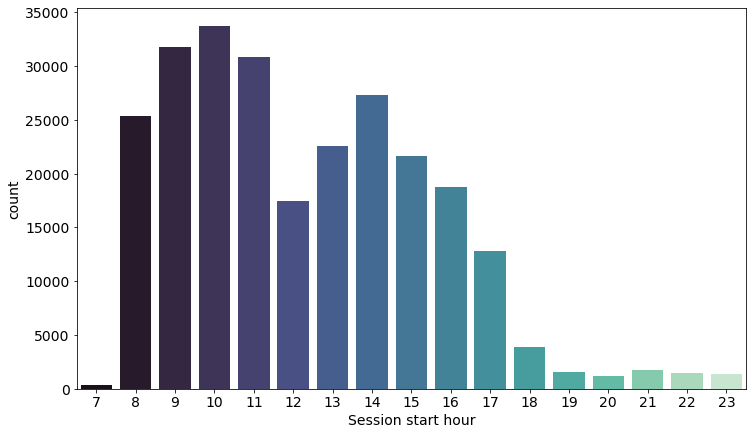

In [11]:
plt.subplots(figsize=(12, 7)) 
sns.countplot(session_start_hour, palette='mako')
plt.xlabel('Session start hour')

Text(0.5, 0, 'Session start hour')

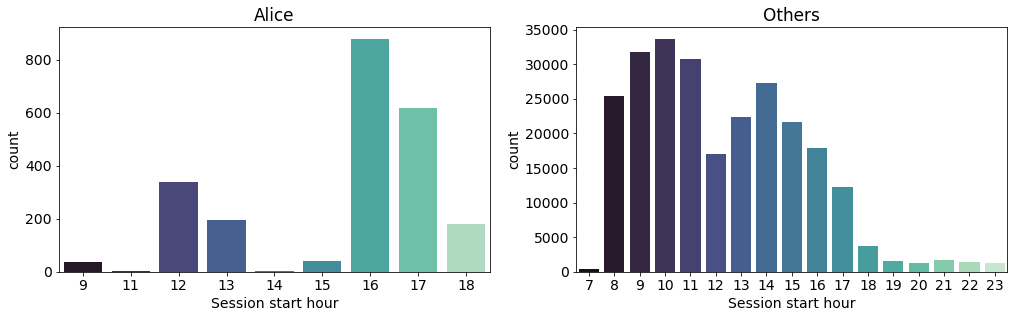

In [12]:
plt.subplots(1, 2, figsize = (17, 4.5)) 

plt.subplot(1, 2, 1)
sns.countplot(session_start_hour[y == 1], palette='mako')
plt.title('Alice')
plt.xlabel('Session start hour')
          
plt.subplot(1, 2, 2)
sns.countplot(session_start_hour[y == 0], palette='mako')
plt.title('Others')
plt.xlabel('Session start hour')

### Feature engineering

In [13]:
# Час сессии
def add_time_features(X_sparse, times):
    hour = times['time1'].apply(lambda ts: ts.hour)
#     one = ((hour >= 1) & (hour < 2)).astype('int').values.reshape(-1, 1)
#     two = ((hour >= 2) & (hour < 3)).astype('int').values.reshape(-1, 1)
#     three = ((hour >= 3) & (hour < 4)).astype('int').values.reshape(-1, 1)
#     four = ((hour >= 4) & (hour < 5)).astype('int').values.reshape(-1, 1)
#     five = ((hour >= 5) & (hour < 6)).astype('int').values.reshape(-1, 1)
#     six = ((hour >= 6) & (hour < 7)).astype('int').values.reshape(-1, 1)
    seven = ((hour >= 7) & (hour < 8)).astype('int').values.reshape(-1, 1)
    eight = ((hour >= 8) & (hour < 9)).astype('int').values.reshape(-1, 1)
    nine = ((hour >= 9) & (hour < 10)).astype('int').values.reshape(-1, 1)
    ten = ((hour >= 10) & (hour < 11)).astype('int').values.reshape(-1, 1)
    eleven = ((hour >= 11) & (hour < 12)).astype('int').values.reshape(-1, 1)
    twelve = ((hour >= 12) & (hour < 13)).astype('int').values.reshape(-1, 1)
    thirteen = ((hour >= 13) & (hour < 14)).astype('int').values.reshape(-1, 1)
    fourteen = ((hour >= 14) & (hour < 15)).astype('int').values.reshape(-1, 1)
    fifteen = ((hour >= 15) & (hour < 16)).astype('int').values.reshape(-1, 1)
    sixteen = ((hour >= 16) & (hour < 17)).astype('int').values.reshape(-1, 1)
    seventeen = ((hour >= 17) & (hour < 18)).astype('int').values.reshape(-1, 1)
    eighteen = ((hour >= 18) & (hour < 19)).astype('int').values.reshape(-1, 1)
    nineteen = ((hour >= 19) & (hour < 20)).astype('int').values.reshape(-1, 1)
    twenty = ((hour >= 20) & (hour < 21)).astype('int').values.reshape(-1, 1)
    twenty_one = ((hour >= 21) & (hour < 22)).astype('int').values.reshape(-1, 1)
    twenty_two = ((hour >= 22) & (hour < 23)).astype('int').values.reshape(-1, 1)
    twenty_three = ((hour >= 23) & (hour < 24)).astype('int').values.reshape(-1, 1)
    twenty_four = ((hour >= 24) & (hour < 1)).astype('int').values.reshape(-1, 1)
    
    objects_to_hstack = [X_sparse, seven, eight, nine, ten, eleven, twelve, thirteen, fourteen, fifteen, sixteen, seventeen, 
                         eighteen, nineteen, twenty, twenty_one, twenty_two, twenty_three, twenty_four] 
    feature_names = ['seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen', 
                     'eighteen', 'nineteen', 'twenty', 'twenty_one', 'twenty_two', 'twenty_three', 'twenty_four']  
    
    X = hstack(objects_to_hstack)
    return X, feature_names

In [14]:
X, time_features = add_time_features(X, train_times)
test, _ = add_time_features(test, test_times)

In [15]:
# Продолжительность сеанса
train_durations = (train_times.max(axis=1) - train_times.min(axis=1)).astype('timedelta64[ms]').astype(int)
test_durations = (test_times.max(axis=1) - test_times.min(axis=1)).astype('timedelta64[ms]').astype(int)

# Масштабирование признаков
scaler = StandardScaler()
train_dur_scaled = scaler.fit_transform(train_durations.values.reshape(-1, 1))
test_dur_scaled = scaler.transform(test_durations.values.reshape(-1, 1))

X = hstack([X, train_dur_scaled])
test = hstack([test, test_dur_scaled])

In [16]:
# Начало сеанса
train_start = train_times[[f'time{i}' for i in range(1, 11)]].min(axis=1)
test_start = test_times[[f'time{i}' for i in range(1, 11)]].min(axis=1)

train_start = scaler.fit_transform(train_start.values.reshape(-1, 1))
test_start = scaler.transform(test_start.values.reshape(-1, 1))

X = hstack([X, train_start])
test = hstack([test, test_start])

In [17]:
# Завершение сеанса
train_end = train_times[[f'time{i}' for i in range(1, 11)]].max(axis=1)
test_end = test_times[[f'time{i}' for i in range(1, 11)]].max(axis=1)

train_end = scaler.fit_transform(train_end.values.reshape(-1, 1))
test_end = scaler.transform(test_end.values.reshape(-1, 1))

X = hstack([X, train_end])
test = hstack([test, test_end])

In [18]:
# День недели, месяц, год
def add_date_features(X_sparse, times):
    day_of_week = times['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
#     month = times['time1'].apply(lambda t: t.month).values.reshape(-1, 1)
#     year = times['time1'].apply(lambda t: t.year).values.reshape(-1, 1) 
    
    objects_to_hstack = [X_sparse, day_of_week]
    feature_names = ['day_of_week']
        
    X = hstack(objects_to_hstack)
    return X, feature_names

In [19]:
X, date_features = add_date_features(X, train_times)
test, _ = add_date_features(test, test_times)

### LogisticRegression 1

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17, shuffle=True)

In [21]:
model_lr = LogisticRegression(C=2, random_state=17, solver='lbfgs', multi_class='multinomial', max_iter=190)
model_lr.fit(X_train, y_train)

train_predictions_lr = model_lr.predict_proba(X_train)[:, 1]
test_predictions_lr = model_lr.predict_proba(X_test)[:, 1]

train_score = roc_auc_score(y_train, train_predictions_lr)
test_score = roc_auc_score(y_test, test_predictions_lr)
                            
print(f'Train score: {round(np.mean(train_score), 5)}, Test score: {round(np.mean(test_score), 5)}')

Train score: 0.99372, Test score: 0.98599


## LogisticRegression 2

In [22]:
model_lr2 = LogisticRegression(C=3, random_state=17, solver='lbfgs', multi_class='multinomial', max_iter=190)
model_lr2.fit(X_train, y_train)

train_predictions_lr2 = model_lr2.predict_proba(X_train)[:, 1]
test_predictions_lr2 = model_lr2.predict_proba(X_test)[:, 1]

train_score2 = roc_auc_score(y_train, train_predictions_lr2)
test_score2 = roc_auc_score(y_test, test_predictions_lr2)
                            
print(f'Train score: {round(np.mean(train_score2), 5)}, Test score: {round(np.mean(test_score2), 5)}')

Train score: 0.99474, Test score: 0.98647


### LogisticRegression 3

In [23]:
model_lr3 = LogisticRegression(C=4, random_state=17, solver='lbfgs', multi_class='multinomial', max_iter=190)
model_lr3.fit(X_train, y_train)

train_predictions_lr3 = model_lr3.predict_proba(X_train)[:, 1]
test_predictions_lr3 = model_lr3.predict_proba(X_test)[:, 1]

train_score3 = roc_auc_score(y_train, train_predictions_lr3)
test_score3 = roc_auc_score(y_test, test_predictions_lr3)
                            
print(f'Train score: {round(np.mean(train_score3), 5)}, Test score: {round(np.mean(test_score3), 5)}')

Train score: 0.99551, Test score: 0.98665


### LogisticRegression 4

In [24]:
model_lr4 = LogisticRegression(C=25, random_state=17, solver='lbfgs', multi_class='multinomial', max_iter=205)
model_lr4.fit(X_train, y_train)

train_predictions_lr4 = model_lr4.predict_proba(X_train)[:, 1]
test_predictions_lr4 = model_lr4.predict_proba(X_test)[:, 1]

train_score4 = roc_auc_score(y_train, train_predictions_lr4)
test_score4 = roc_auc_score(y_test, test_predictions_lr4)
                            
print(f'Train score: {round(np.mean(train_score4), 5)}, Test score: {round(np.mean(test_score4), 5)}')

Train score: 0.99738, Test score: 0.98589


In [25]:
scores = pd.DataFrame({
    'LogisticRegression': test_predictions_lr,
    'LogisticRegression2': test_predictions_lr2,
    'LogisticRegression3': test_predictions_lr3,
    'LogisticRegression4': test_predictions_lr4,
})

,LogisticRegression,LogisticRegression2,LogisticRegression3,LogisticRegression4
0,0.00001,0.00000,0.00000,0.00000
1,0.00014,0.00007,0.00007,0.00001
2,0.00011,0.00006,0.00016,0.00003
3,0.00128,0.00089,0.00087,0.00017
4,0.00003,0.00001,0.00000,0.00000


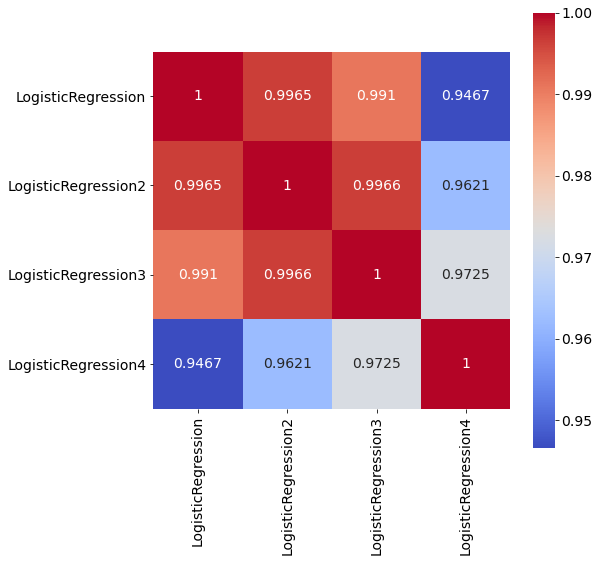

In [26]:
corr = scores.corr()

fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(corr, annot=True, fmt='.4g', square=True, cmap='coolwarm', ax=axes)

scores.head()

### VotingClassifier

In [27]:
model_lr = LogisticRegression(C=2, random_state=27, solver='lbfgs', multi_class='multinomial', max_iter=190)
model_lr2 = LogisticRegression(C=3, random_state=27, solver='lbfgs', multi_class='multinomial', max_iter=190)
model_lr3 = LogisticRegression(C=4, random_state=27, solver='lbfgs', multi_class='multinomial', max_iter=190)
model_lr4 = LogisticRegression(C=25, random_state=27, solver='lbfgs', multi_class='multinomial', max_iter=205)

In [28]:
model_vc = VotingClassifier(estimators=[
    ('LogisticRegression', model_lr), 
    ('LogisticRegression2', model_lr2), 
    ('LogisticRegression3', model_lr3), 
    ('LogisticRegression4', model_lr4)
], voting='soft')

In [29]:
model_vc.fit(X_train, y_train)

train_predictions_vc = model_vc.predict_proba(X_train)[:, 1]
test_predictions_vc = model_vc.predict_proba(X_test)[:, 1]

train_score_vc = roc_auc_score(y_train, train_predictions_vc)
test_score_vc = roc_auc_score(y_test, test_predictions_vc)

print(f'Train score: {round(np.mean(train_score_vc), 5)}, Test score: {round(np.mean(test_score_vc), 5)}')

Train score: 0.99588, Test score: 0.98642


In [30]:
%%time
cv_train = cross_val_score(model_vc, X_train, y_train, cv=10, scoring='roc_auc', n_jobs=4)
print('CV scores', cv_train)
print('CV mean: {}, CV std: {}'.format(cv_train.mean(), cv_train.std()))

CV scores [0.98707581 0.9851065  0.981174   0.98301238 0.98506595 0.97516289
 0.98476034 0.97812932 0.98561221 0.98770939]
CV mean: 0.9832808781774327, CV std: 0.0038093032190054154
Wall time: 4min 3s


In [31]:
%%time
cv_test = cross_val_score(model_vc, X_test, y_test, cv=10, scoring='roc_auc', n_jobs=4)
print('CV scores', cv_test)
print('CV mean: {}, CV std: {}'.format(cv_test.mean(), cv_test.std()))

CV scores [0.98373988 0.96961756 0.98022726 0.98094632 0.97302813 0.97309634
 0.99079716 0.96273959 0.9896461  0.97172927]
CV mean: 0.9775567604665986, CV std: 0.008574700450858466
Wall time: 1min 45s


In [32]:
# CV mean: 0.9775567604665986, CV std: 0.008574700450858466 - 0.95838

### Result

In [33]:
test_pred = model_vc.predict_proba(test)[:, 1]

In [34]:
write_to_submission_file(test_pred, RES_PATH) 